# Overview

 - Runs prediction of specified model on images in samples folder
 - Ensure images added to samples folder have white background with black pen
 - Model architecture defined in models/cnn_base.py
 - Model checkpoint loaded from ocr_letters.pth

In [1]:
import sys
sys.path.append("../")
import torch
import json
from PIL import Image
from torchvision import transforms
from models.cnn_base import CNNBaseModel
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# import wavemix    # Model architecture I was testing -- seems to do better but definitely needs gpu to train
# from wavemix.classification import WaveMix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_CKPT = Path("model_ckpts/ocr_letters.pth")
CLASS_MAP = Path("emnist_letters_map.json")

with open(str(CLASS_MAP), 'r') as file:
    class_map = json.load(file)

model = CNNBaseModel()


In [2]:

model.load_state_dict(torch.load(str(MODEL_CKPT), map_location=device)) #When loading model from weights make sure it matches the specified architecture
model.eval()

def prep_img_for_model(model, img_path):
    """
    img_path is pathlib Path object
    Processes input image (Black pen, white background)
    Returns image tensor formatted for given model
        Resized - 28x28
        Inverted colors
    """
    image = Image.open(str(img_path)).convert('L')
    image = Image.eval(image, lambda x: 255 - x) #Invert colors

    transform = transforms.Compose([    #Resize for model and convert to tensor
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    # if isinstance(model, WaveMix):
    #     image_tensor = image_tensor.repeat(1,3,1,1)
    
    return image_tensor

def get_class(class_num): #Convert model's number prediction to letter prediction
    return class_map[str(class_num - 1)]

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # transforms.Resize((256, 256))
])

# Load EMNIST letters dataset
data_root = './data'
emnist_data = datasets.EMNIST(root=data_root, split='letters', train=True, download=True, transform=transform)
train_loader = DataLoader(emnist_data, batch_size=64, shuffle=True)


### Evaluation Notes

 - Below code generates evaluation diagram by displaying the predictions above each letter
 - Left most letter is highest confidence, the right side ones are lower confidence

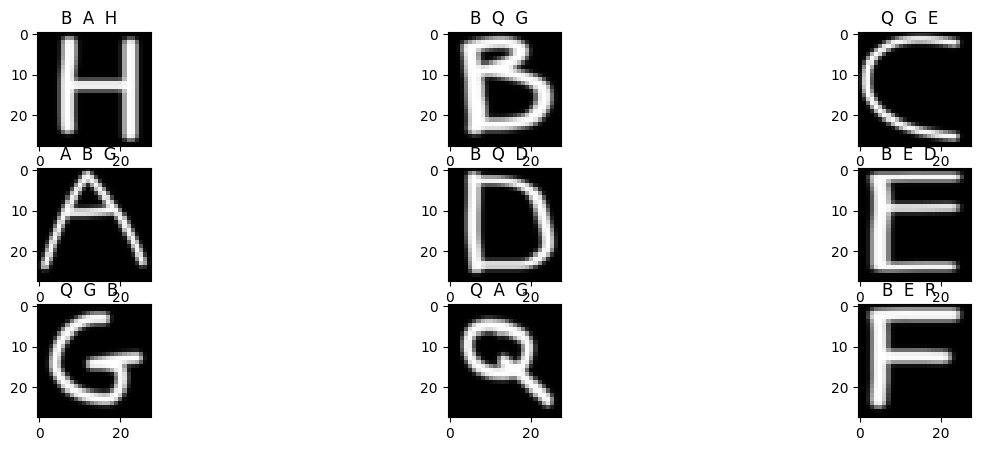

In [4]:
LETTERS_DIR = Path("samples/letters/")
fig, axs = plt.subplots(3, 3, figsize=(15, 5))
for ind, img in enumerate(LETTERS_DIR.iterdir()):
    image_tensor = prep_img_for_model(model, str(img))

    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    _, top3 = torch.topk(output, 3)
    top3 = top3.flatten().tolist()
    
    top3_preds = ''
    for pred in top3:
        top3_preds += f"{get_class(pred)}  "
    

    axs[ind // 3, ind % 3].imshow(image_tensor.squeeze(0).squeeze(0), cmap='gray')
    axs[ind // 3, ind % 3].set_title(top3_preds)
    # axs[ind // 3, ind % 3].set_title(get_class(predicted_class.item()))

    